In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import math

In [2]:
def cross_in_func(pop,*kwargs):
    # kwargs 
    # first: linear, sigmoid 1 or 2...
    # second: x0
    # third: a
    # fouth: make superior part of the sigmoid linear (True) or not
    if not kwargs or kwargs[0] == 0 or kwargs[0] == 'lin':
        return pop
    elif kwargs[0] == 1 or kwargs[0] == 'sigmoid1':
        x0, a = kwargs[1], kwargs[2]
        cival = 1/(1+np.exp(-a*(pop-x0))) 
        if len(kwargs) == 4 and kwargs[3]:
            cival = min(cival, pop)
        return cival
    elif kwargs[0] == 2 or kwargs[0] == 'sigmoid2':
        x0, a = kwargs[1], kwargs[2]
        return pop/(1+np.exp(-a*(pop-x0)))

def fs_evo_eq(t,fs,pis,qs,l,lci,ci_kwargs=[0, ]):
    dfsdt = [0.0,]
    for i in range(len(fs)-1):
        site_i = i+1
        dfdt = fs[0]*((1-l)*pis[i]+l*fs[site_i]) - fs[site_i]/qs[i] #- lci*fs[site_i]*(sum(fs[1:site_i])+sum(fs[site_i+1:]))
        for j in range(len(fs)-1):
            site_j = j+1
            if site_j != site_i:
                dfdt += -lci*fs[site_i]*cross_in_func(fs[site_j],*ci_kwargs)
        dfsdt.append(dfdt)
    dfsdt[0] = -1*sum(dfsdt[1:])
    return dfsdt

# LINES TO EVALUATE PERFORMANCE
# start_time = time.time()
# for _ in range(100):
#     sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci), method='RK23') # dense_output=True
# print("--- %s seconds ---" % (time.time() - start_time)

In [3]:
# temporary put here the function to evaluate the nonlin ci limit:
def f0poly_sols_nlinci(pis, qs, l, lci):
    rs = [1/q for q in qs]
    pi1, pi2 = pis
    r1, r2 = rs
    a = -(l**2)
    b = l*(l+lci+r1+r2+(1-l)*(pi1+pi2))
    c = -l*(lci+r1+r2) - (1-l)*(pi1*r2+pi2*r1+pi2*lci) - r1*r2 - r2*lci
    d = r1*r2 + r2*lci
     # step 1: delta0 and elta 1
    delta0 = b**2 - 3*a*c
    delta1 = 2*b**3 - 9*a*b*c + 27*a**2*d
    # step 2: computation of C:
    if delta0 == 0.0 and delta1 != 0.0:
        C = delta1**(1/3) # cubic_root[(delta1 + sqrt(delta1**2+0))/2]
    elif delta0 == 0.0 and delta1 == 0.0:
        C = 1.0 # so in the next step delta0/C yields 0.0 instead of NaN (0.0/0.0)
    else:
        radicand0 = delta1**2 - 4*delta0**3
        if radicand0 < 0:
            root0 = complex(0,math.sqrt(-1*radicand0))
        else:
            root0 = complex(math.sqrt(radicand0),0)
        radicand1 = (delta1 + root0)/2
        C = radicand1**(1/3)
    # 3: Final solution
    ksi = complex(-1, math.sqrt(3))/2
    f0_roots, f0_roots_abs = [], []
    for k in range(3):
        f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
        f0_roots.append(f0_root), f0_roots_abs.append(abs(f0_root))
    return f0_roots_abs

def fs_sols_nlinci(f0, pis, qs, l, lci):
    rs = [1/q for q in qs]
    f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
    f2 = f0*(1-l)*pis[1]/(rs[1] - l*f0)
    return f1,f2

In [3]:
fs0 = [1.0, 0.0, 0.0]
# fs0 = 0.18556057786706026, 0.7985730161805377+0.001, 0.015866405950984014-0.001 # fixed point for l, lci = 0.6, 0.6...
# fs0 = [0.3929690394231026, 0.3164637304137582, 0.2905672301666127] # unstable(?) fixed point 
# fs0 = 0.18, 0.79, 0.015 # fixed point for l, lci = 0.6, 0.6...
pis, qs, l, lci = [0.1, 0.1], [9.0, 10.0], 0.6, 0.6
# pis, qs, l, lci = [0.2, 0.2], [9.0, 10.0], 0.2, 0.2

# No Cross inhibition:
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, 0.0))
print(f'NO Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')

# Linear Cross inhibition:
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
print(f'Linear Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')

# Sigmoid1 Cross-inhibition:
ci_kwargs = [1, 0.5, 100]
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, ci_kwargs))
print(f'Sigmoid1 Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')

# Sigmoid2 Cross-inhibition: (sigmoid+lin behavior)
ci_kwargs = [2, 0.5, 100]
sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, ci_kwargs))
print(f'Sigmoid2 Cross-inhibition: {sol.y[0][-1]}, {sol.y[1][-1]}, {sol.y[2][-1]}')


NO Cross-inhibition: 0.14952431576105388, 0.27732971671936757, 0.5731459675195786
Linear Cross-inhibition: 0.16635040808426707, 0.01321788619439089, 0.8204317057213423
Sigmoid1 Cross-inhibition: 0.15430065288211006, 0.00999779009068148, 0.8357015570272092
Sigmoid1 Cross-inhibition: 0.1543062291002355, 0.011904457407686784, 0.8337893134920775


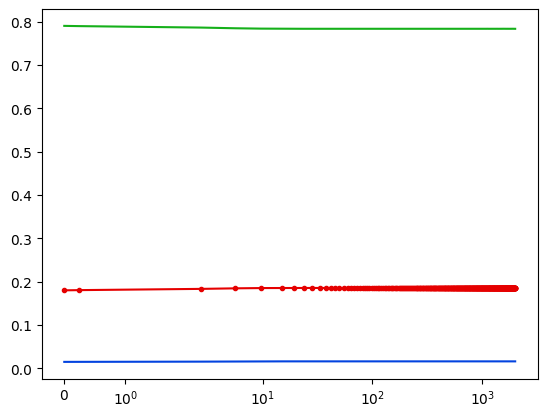

In [84]:
fig, ax = plt.subplots()
ax.set(xscale='symlog')
ax.plot(sol.t, sol.y[0], color='xkcd:red', marker='.')
ax.plot(sol.t, sol.y[1], color='xkcd:green')
ax.plot(sol.t, sol.y[2], color='xkcd:blue')

## Linear vs sigmoid2

In [5]:
lci_eq_1 = True
# lci_eq_1 = False # uncoment this to make lci whatever in the loops below (check what is there)
lci = 1.0

# ls = np.arange(0.0, 1.0, 0.05)
ls = np.concatenate([np.arange(0.0, 0.22, 0.02), np.arange(0.25, 1.0, 0.05)])
pis, qs = [0.2, 0.2], [9.0, 10.0]
fs0 = [1.0, 0.0, 0.0]

# sigmoid cross inhibition arguments:
# ci_kwargs = [2, 0.5, 20]
# varying x0:

noci_evo = {'f0':[], 'f1':[], 'f2':[]} 
lin_evo = {'f0':[], 'f1':[], 'f2':[]}
# sig2_evo = {'f0':[], 'f1':[], 'f2':[]}
for l in ls:
    if not lci_eq_1:
        lci = l
    solnoci = solve_ivp(fs_evo_eq, [0, 2500], fs0, args=(pis, qs, l, 0.0))
    sollin = solve_ivp(fs_evo_eq, [0, 2500], fs0, args=(pis, qs, l, lci))
    # solsig = solve_ivp(fs_evo_eq, [0, 2500], fs0, args=(pis, qs, l, lci, ci_kwargs))
    for i in range(len(pis)+1):
        # for evo,sol in zip([noci_evo, lin_evo, sig2_evo], [solnoci, sollin, solsig]):
        for evo,sol in zip([noci_evo, lin_evo], [solnoci, sollin]):
            evo[f'f{i}'].append(sol.y[i][-1])


sig2_evo = {}
cimode = 2
# varying x0:
# x0s = []
# a = 100
# varying a:
x0 = 0.3
aparams = [10, 20, 50, 500]

paramSig = aparams
for param in paramSig:
    sig2_evo[param] = {'f0':[], 'f1':[], 'f2':[]}
    ci_kwargs = [cimode, x0, param] if type(param)==int else [cimode, param, a]
    for l in ls:
        if not lci_eq_1:
            lci = l
        solsig = solve_ivp(fs_evo_eq, [0, 2500], fs0, args=(pis, qs, l, lci, ci_kwargs))
        for i in range(len(pis)+1):
            sig2_evo[param][f'f{i}'].append(solsig.y[i][-1])

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_1256/722307402.py:17: RuntimeWarning: overflow encountered in exp
  return pop/(1+np.exp(-a*(pop-x0)))


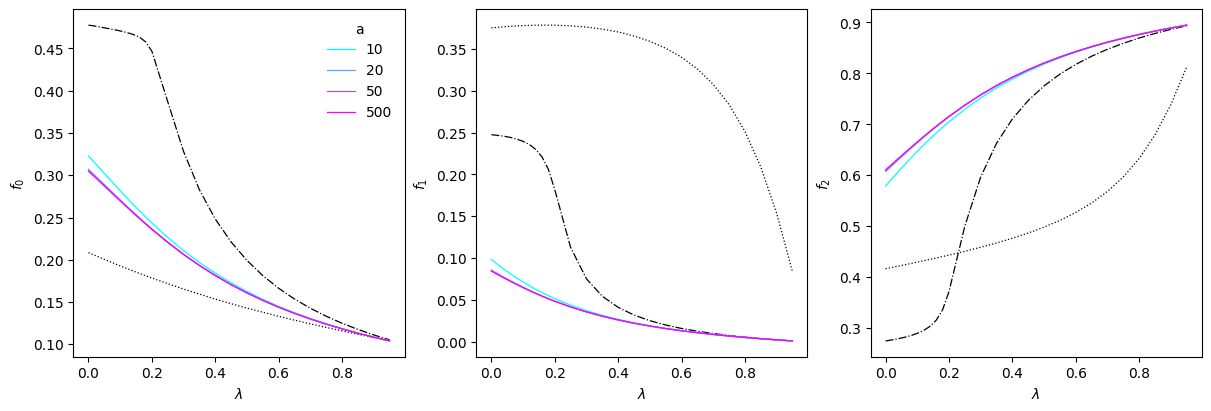

In [6]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)

# paramSig, legTitle = x0s, '$x_0$'
paramSig, legTitle = aparams, 'a'
colorSig = plt.cm.cool(np.linspace(0,1,len(paramSig)))

for i in range(len(pis)+1):
    ax[i].plot(ls, noci_evo[f'f{i}'], color='k', ls=':', lw=0.9)
    ax[i].plot(ls, lin_evo[f'f{i}'], color='k', ls='-.', lw=0.9)
    for param,c in zip(paramSig,colorSig):
        label = param if i==0 else '_nolabel_'
        ax[i].plot(ls, sig2_evo[param][f'f{i}'], color=c, ls='-', lw=0.9, label=param)
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

ax[0].legend(frameon=False, title=legTitle)

pichain = '_'.join([str(pi) for pi in pis])
qchain = '_'.join([str(q) for q in qs])
# fig.savefig(f'lambdaEvofs_sig2_change_a_x0_{x0}_pis_{pichain}_qs_{qchain}_lci_1.png')


In [17]:
Nsites = 2
i = 1
a = list(range(1,Nsites+1))
print(a)
a.remove(i)
print(a)
type(a)

[1, 2]
[2]


list

In [10]:
a

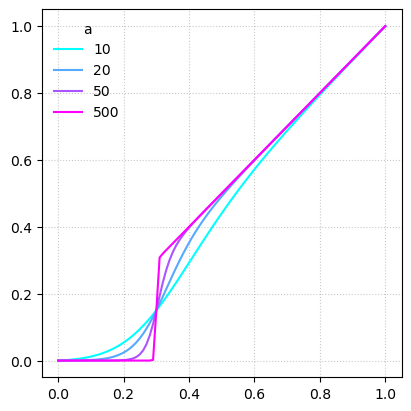

In [45]:
# plot the sigmoid functions used:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
ax.grid(color='xkcd:gray', ls=':', alpha=0.5)
xs = np.arange(0.0, 1.01, 0.01)
for param,c in zip(paramSig,colorSig):
    ci_kwargs = [cimode, x0, param] if type(param)==int else [cimode, param, a]
    sig2 = cross_in_func(xs, *ci_kwargs)
    ax.plot(xs, sig2, color=c, label=param)
ax.legend(frameon=False, title=legTitle)
fig.savefig('sig2_sample.png')

## Fix lambda', vary lambda

In [12]:
lcis = [0.1, 0.3, 0.6, 0.9]
ls = np.arange(0.0, 1.0, 0.05)

fs0 = [1.0, 0.0, 0.0]
pis, qs = [0.1, 0.1], [9.0, 10.0]

#sigmoid cross inhibition arguments:
ci_kwargs = [1, 0.5, 100, 0]

lcis_l_evo = {}
for lci in lcis:
    lcis_l_evo[lci] = {'lin':{'f0':[], 'f1':[], 'f2':[], 'Q':[], 'Qsimple':[]}, 'sig1':{'f0':[], 'f1':[], 'f2':[], 'Q':[], 'Qsimple':[]}}
    for l in ls:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2500], fs0, args=(pis, qs, l, lci))
        lcis_l_evo[lci]['lin']['f2'].append(sol.y[2][-1])
        lcis_l_evo[lci]['lin']['f1'].append(sol.y[1][-1])
        lcis_l_evo[lci]['lin']['f0'].append(sol.y[0][-1])
        lcis_l_evo[lci]['lin']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        lcis_l_evo[lci]['lin']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, ci_kwargs))
        lcis_l_evo[lci]['sig1']['f2'].append(sol.y[2][-1])
        lcis_l_evo[lci]['sig1']['f1'].append(sol.y[1][-1])
        lcis_l_evo[lci]['sig1']['f0'].append(sol.y[0][-1])
        lcis_l_evo[lci]['sig1']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        lcis_l_evo[lci]['sig1']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])

In [7]:
lcis_l_evo_nlinCIsol = {}
for lci in lcis:
    lcis_l_evo_nlinCIsol[lci] = {'f0':[], 'f1':[],'f2':[], 'Q':[], 'Qsimple':[]}
    for l in ls:
        f0s = f0poly_sols_nlinci(pis, qs, l, lci)
        f1, f2 = fs_sols_nlinci(f0s[1], pis, qs, l, lci)
        lcis_l_evo_nlinCIsol[lci]['f2'].append(f2)
        lcis_l_evo_nlinCIsol[lci]['f1'].append(f1)
        lcis_l_evo_nlinCIsol[lci]['f0'].append(f0s[1])

/tmp/ipykernel_65946/699287256.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
/tmp/ipykernel_65946/699287256.py:30: RuntimeWarning: invalid value encountered in scalar multiply
  f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
/tmp/ipykernel_65946/699287256.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
/tmp/ipykernel_65946/699287256.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  f2 = f0*(1-l)*pis[1]/(rs[1] - l*f0)


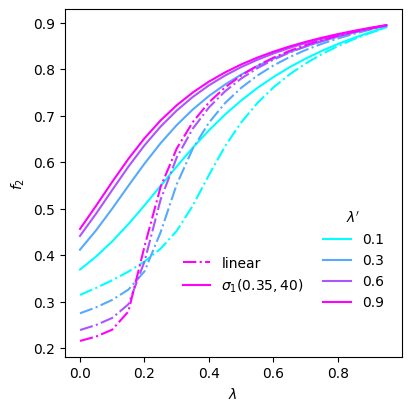

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
mag, maglabel = 'f2', '$f_2$'
# mag, maglabel= 'Q', '$Q$'
# mag, maglabel= 'Qsimple', '$Q_1$'
ax.set(xlabel="$\lambda$", ylabel=maglabel)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(lcis)))

for (lci,l_evo),c in zip(lcis_l_evo.items(),colors):
    ax.plot(ls, l_evo['lin'][mag], ls='-.', color=c)
    ax.plot(ls, l_evo['sig1'][mag], ls='-', color=c, label=f'{lci}')

ax.legend(title="$\lambda'$", frameon=False, loc=(0.75,0.12))

ax2 = fig.add_axes((1,1,1,1))
ax2.set_visible(False)
ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

# fig.savefig(f'x_lambda_y_{mag}_ci_num_int_compare_lin_sig1.png')
fig.savefig(f'x_lambda_y_{mag}_ci_num_int_compare_lin_sig1supLin.png')

### Comparison bt numInt and approxSol results, for the nonlinear ci

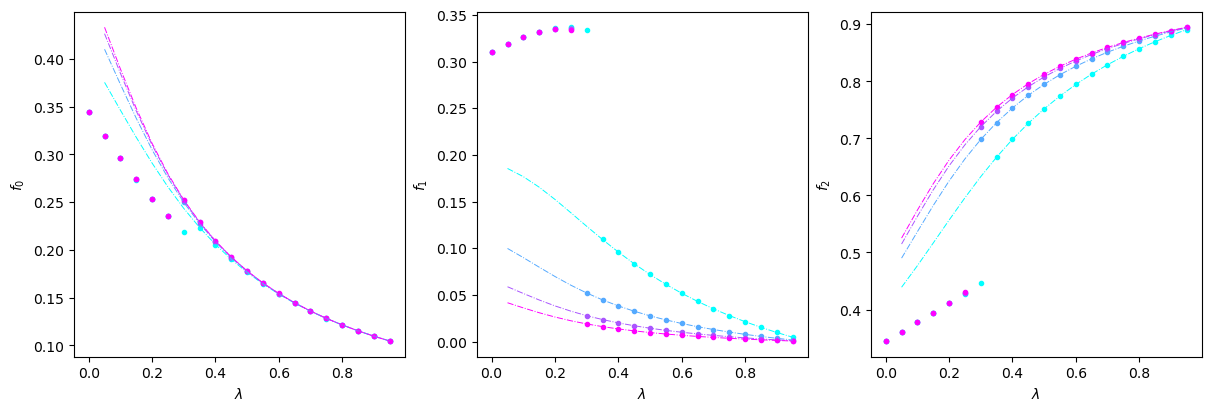

In [13]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
# mag, maglabel = 'f2', '$f_2$'
# mag, maglabel= 'Q', '$Q$'
# mag, maglabel= 'Qsimple', '$Q_1$'

ax[0].set(xlabel="$\lambda$", ylabel="$f_0$")
ax[1].set(xlabel="$\lambda$", ylabel="$f_1$")
ax[2].set(xlabel="$\lambda$", ylabel="$f_2$")

colors = plt.cm.cool(np.linspace(0.0, 1.0, len(lcis)))

for (lci,l_evo),c in zip(lcis_l_evo.items(),colors):
    # ax.plot(ls, l_evo['lin'][mag], ls='-.', color=c)
    # ax.plot(ls, l_evo['sig1'][mag], ls='-', color=c, label=f'{lci}')
    ax[0].plot(ls, l_evo['sig1']['f0'], lw=0, marker='.', color=c, label=f'{lci}')
    ax[1].plot(ls, l_evo['sig1']['f1'], lw=0, marker='.', color=c, label=f'{lci}')
    ax[2].plot(ls, l_evo['sig1']['f2'], lw=0, marker='.', color=c, label=f'{lci}')

for (lci,l_evo),c in zip(lcis_l_evo_nlinCIsol.items(),colors):
    ax[0].plot(ls, l_evo['f0'], ls='-.', lw=0.7, color=c)
    ax[1].plot(ls, l_evo['f1'], ls='-.', lw=0.7, color=c)
    ax[2].plot(ls, l_evo['f2'], ls='-.', lw=0.7, color=c)

## Fix lambda, vary lambda'

In [25]:
ls = [0.1, 0.3, 0.6, 0.9]
lcis = np.arange(0.0, 1.0, 0.05)

ls_lci_evo = {}
for l in ls:
    ls_lci_evo[l] = {'lin':{'f2':[], 'Q':[], 'Qsimple':[]}, 'sig1':{'f2':[], 'Q':[], 'Qsimple':[]}}
    # lci_evo = {'lin':[], 'sig1':[]}
    for lci in lcis:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
        ls_lci_evo[l]['lin']['f2'].append(sol.y[2][-1])
        ls_lci_evo[l]['lin']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        ls_lci_evo[l]['lin']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, [1, 0.35, 40, 1]))
        ls_lci_evo[l]['sig1']['f2'].append(sol.y[2][-1])
        ls_lci_evo[l]['sig1']['Q'].append(sol.y[2][-1]-2*sol.y[1][-1])
        ls_lci_evo[l]['sig1']['Qsimple'].append(sol.y[2][-1]-sol.y[1][-1])


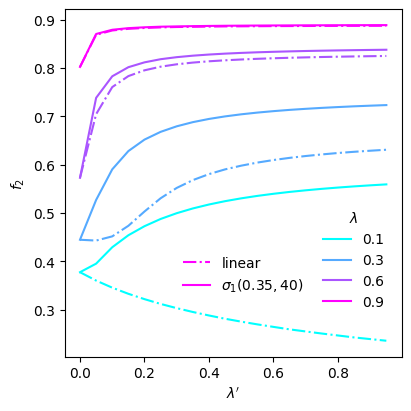

In [26]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
mag, maglabel= 'f2', '$f_2$'
# mag, maglabel= 'Q', '$Q$'
ax.set(xlabel="$\lambda'$", ylabel=maglabel)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls)))

for (l,lci_evo),c in zip(ls_lci_evo.items(),colors):
    ax.plot(lcis, lci_evo['lin'][mag], ls='-.', color=c)
    ax.plot(lcis, lci_evo['sig1'][mag], ls='-', color=c, label=f'{l}')

ax.legend(title='$\lambda$', frameon=False, loc=(0.75,0.12))

ax2 = fig.add_axes((1,1,1,1))
ax2.set_visible(False)
ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

# fig.savefig(f'x_lambdaci_y_{mag}_ci_num_int_compare_lin_sig1.png')
fig.savefig(f'x_lambdaci_y_{mag}_ci_num_int_compare_lin_sig1supLin.png')
# fig.savefig('ci_num_int_compare_lin_sig1_lci_evo_f2.png')

# lambda = lambda'

## compare numInt and aprox sol

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/699287256.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/699287256.py:30: RuntimeWarning: invalid value encountered in scalar multiply
  f0_root = -1/(3*a)*(b + ksi**k*C + delta0/(C*ksi**k))
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/699287256.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  f1 = f0*(1-l)*pis[0]/(lci + rs[0] - l*f0)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/699287256.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  f2 = f0*(1-l)*pis[1]/(rs[1] - l*f0)
/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/2205214336.py:11: RuntimeWarning: overflow encountered in exp
  cival = 1/(1+np.exp(-a*(pop-x0)))


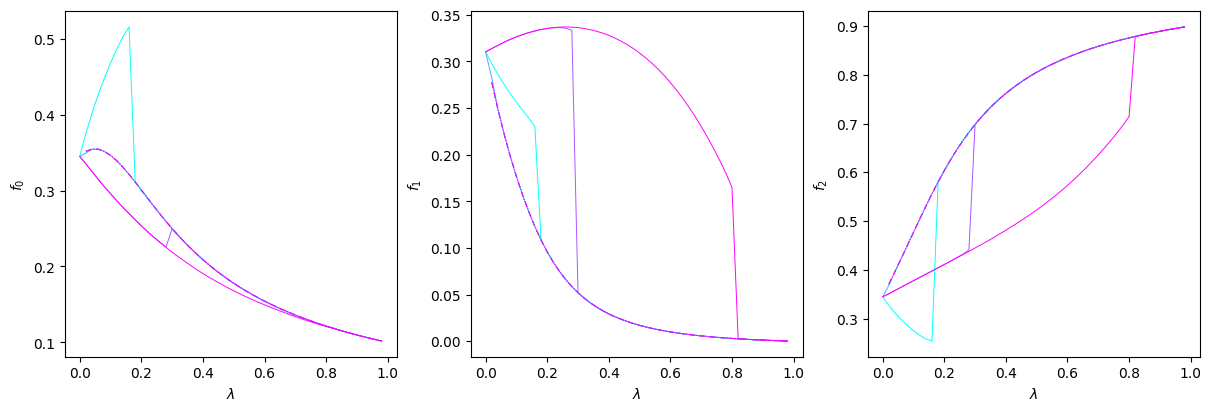

In [107]:
fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
ax[0].set(xlabel="$\lambda$", ylabel="$f_0$")
ax[1].set(xlabel="$\lambda$", ylabel="$f_1$")
ax[2].set(xlabel="$\lambda$", ylabel="$f_2$")

ls = np.arange(0.0, 1.0, 0.02)

x0s = [0.2, 0.35, 0.5, 0.8]
a = 100
lci_factor = 1.0
for x0,c in zip(x0s, colors):
    # numerical integration
    fs_evo = [[], [], []]
    for l in ls:
        lci = l*lci_factor
        if lci > 1.0:
            lci = 1.0
        sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci, (1, x0, a, 0)))
        for i in range(3):
            fs_evo[i].append(sol.y[i][-1])
    for i in range(3):
        label=rf"$x_0 = {x0}$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], ls='-', color=c, lw=0.7, label=label)
    # approximate soluytion:
    fs_evo = [[], [], []]
    for l in ls:
        lci = l*lci_factor
        if lci > 1.0:
            lci = 1.0
        f0s = f0poly_sols_nlinci(pis, qs, l, lci)
        f1, f2 = fs_sols_nlinci(f0s[1], pis, qs, l, lci)
        fs_evo[0].append(f0s[1]), fs_evo[1].append(f1), fs_evo[2].append(f2)
    for i in range(3):
        ax[i].plot(ls, fs_evo[i], ls='-.', color=c, lw=0.7)



## Cross inhibition for different model param's (qs, pis)

/var/folders/m0/czh93qvd5t1g803_x1pzy8g00000gt/T/ipykernel_31152/2205214336.py:11: RuntimeWarning: overflow encountered in exp
  cival = 1/(1+np.exp(-a*(pop-x0)))


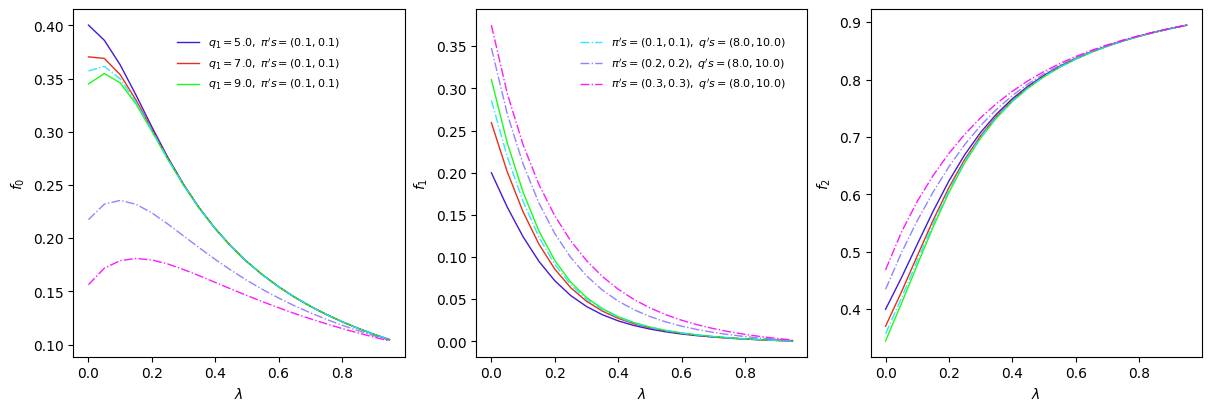

In [66]:
ls = np.arange(0.0, 1.0, 0.05)
fs0 = [1.0, 0.0, 0.0]

fig, ax = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
for i in range(3):
    ax[i].set(xlabel='$\lambda$', ylabel=f'$f_{i}$')

# no cross inhibition:
# fs_evo = [[], [], []]
# lci = 0.0
# for l in ls:
#     sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
#     for i in range(3):
#         fs_evo[i].append(sol.y[i][-1])
# for i in range(3):
#     label='no c.i.' if i==0 else '_nolabel_'
#     ax[i].plot(ls, fs_evo[i], ls='-', color='k', lw=1.0, label=label)

# cross inhibition = interdependence
# fs_evo = [[], [], []]
# for l in ls:
#     lci = l
#     sol = solve_ivp(fs_evo_eq, [0, 2000], fs0, args=(pis, qs, l, lci))
#     for i in range(3):
#         fs_evo[i].append(sol.y[i][-1])
# for i in range(3):
#     # label=r"$\lambda' = \lambda$" if i==0 else '_nolabel_'
#     label=r"linear" if i==0 else '_nolabel_'
#     ax[i].plot(ls, fs_evo[i], ls='-.', color='xkcd:black', lw=1.0, label=label)


############ cross inhibition = sigmoid of the inhibiting population ############
x0, a = 0.35, 100

# different q1s:
q1s = [5.0, 7.0, 9.0]
q2 = 10.0
pis = [0.1, 0.1]

colors = plt.cm.brg(np.linspace(0.1,0.99,len(q1s)))
for q1,c in zip(q1s,colors): # threshold of the step function
    fs_evo = [[], [], []]
    ci_args = (1, x0, a, 0)
    qs = [q1, q2]
    for l in ls:
        lci = l
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci, ci_args))
        for i in range(3):
            fs_evo[i].append(sol.y[i][-1])
    for i in range(3):
        label=rf"$q_1 = {q1}, \; \pi's = ({pis[0]}, {pis[1]})$" if i==0 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c)
ax[0].legend(loc=(0.30,0.75), fontsize=8, frameon=False)

# different pis:
pisl = [[0.1, 0.1], [0.2, 0.2], [0.3, 0.3]]
qs = [8.0, 10.0]

colors = plt.cm.cool(np.linspace(0.1,0.99,len(pisl)))
for pis,c in zip(pisl,colors): # threshold of the step function
    fs_evo = [[], [], []]
    ci_args = (1, x0, a, 0)
    for l in ls:
        lci = l
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci, ci_args))
        for i in range(3):
            fs_evo[i].append(sol.y[i][-1])
    for i in range(3):
        label=rf"$\pi's = ({pis[0]}, {pis[1]}), \; q's = ({qs[0]}, {qs[1]})$" if i==1 else '_nolabel_'
        ax[i].plot(ls, fs_evo[i], label=label, lw=1.0, alpha=0.9, color=c, ls='-.')
ax[1].legend(loc=(0.30,0.75), fontsize=8, frameon=False)


## Stationary times

In [3]:
def evoTimeDeriv(sol, getFullEvo=False, getStatTime=True, thresh=1e-4):
    evo_derivs = []
    for j in range(len(sol.y)):
        if getFullEvo:
            dfj = []
        if getStatTime:
            statTimej = []
        for i in range(len(sol.t)):
            if i == 0: # forward derivative at timestep 0
                deriv = (sol.y[j][1]-sol.y[j][0])/(sol.t[1]-sol.t[0])
            elif i == len(sol.t)-1: # backwards derivative at the last timestep
                deriv = (sol.y[j][-1]-sol.y[j][-2])/(sol.t[-1]-sol.t[-2])
            else: # central derivative at the last point
                deriv = (sol.y[j][i+1]-sol.y[j][i-1])/(sol.t[i+1]-sol.t[i-1])
            if getFullEvo:
                dfj.append(deriv)
            if getStatTime:
                if deriv <= thresh and sol.t[i] >= 10:
                    statTimej.append(sol.t[i])
                    break
        if getFullEvo:
            evo_derivs.append(dfj)
    if getFullEvo:
        return evo_derivs
    if getStatTime:
        return max(statTimej)

91 47


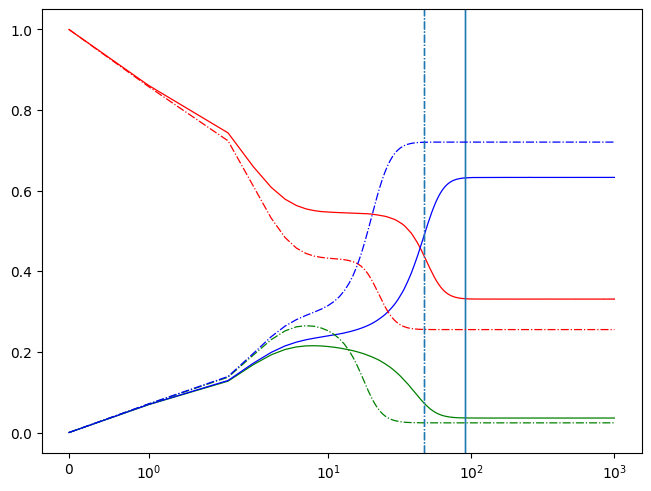

In [7]:
pis, qs = [0.1, 0.1], [9.0, 10.0]
l, lci = 0.3, 1.0
fs0 = [1.0, 0.0, 0.0]
t_eval = np.arange(0,1001,1)

solLin = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci), t_eval=t_eval)
tssLin = evoTimeDeriv(solLin)
solSig2 = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci, [2, 0.3, 10.0]), t_eval=t_eval)
tssSig2 = evoTimeDeriv(solSig2)

print(tssLin, tssSig2)

plotEvos = True
if plotEvos:
    fig, ax = plt.subplots(1,1, constrained_layout=True)
    ax.set_xscale('symlog')
    for sol,tss,ls in zip([solLin, solSig2],[tssLin, tssSig2], ['-', '-.']):
        for i,c in enumerate(['r', 'g', 'b']):
            ax.plot(sol.t, sol.y[i], color=c, ls=ls, lw=0.9)
            ax.axvline(tss, 0, 1, ls=ls, lw=0.9)

In [57]:
# Fixing l and varying lci:
ls = [0.1, 0.3, 0.6, 0.9]
lcis = np.arange(0.0, 1.0, 0.05)

# check is this makes the results smoother
t_eval = np.arange(0,1001,1)
# t_eval = None

supLin = 0
supLin = 1

ls_lci_evo_times = {}
for l in ls:
    ls_lci_evo_times[l] = {'lin':[], 'sig1':[]}
    for lci in lcis:
        # linear cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci), t_eval=t_eval)
        statTime = evoTimeDeriv(sol)
        ls_lci_evo_times[l]['lin'].append(statTime)
        # sigmoid cross inhibition
        sol = solve_ivp(fs_evo_eq, [0, 1000], fs0, args=(pis, qs, l, lci, [1, 0.35, 40, supLin]), t_eval=t_eval)
        statTime = evoTimeDeriv(sol)
        ls_lci_evo_times[l]['sig1'].append(statTime)

# Fixing lci and varying l:
# lcis = [0.1, 0.3, 0.6, 0.9]
# ls = np.arange(0.0, 1.0, 0.05)

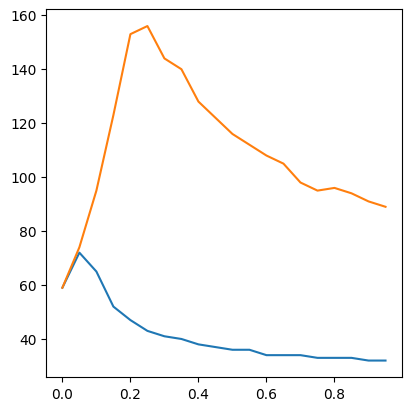

In [45]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)

ax.plot(lcis, ls_lci_evo_times[0.3]['sig1'])
ax.plot(lcis, ls_lci_evo_times[0.3]['lin'])


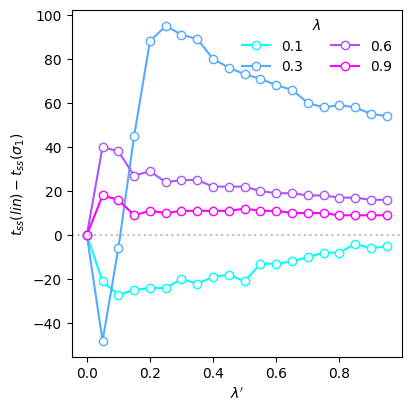

In [60]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls)))

### PLOT the times, simple
# ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}$')
# for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
#     ax.plot(lcis, lci_evo['lin'], ls='-.', color=c)
#     ax.plot(lcis, lci_evo['sig1'], ls='-', color=c, label=f'{l}')

### PLOT time(linear)-time(sigmoid)
relative = False
if relative:
    ax.set(xlabel="$\lambda'$", ylabel=r'$1 - t_{ss}(\sigma_1)/t_{ss}(lin)$')
else:
    ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(lin) - t_{ss}(\sigma_1)$')
for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
    if relative:
        # tdifRel = [abs(tlin-tsig)/tlin for tlin,tsig in zip(lci_evo['lin'], lci_evo['sig1'])]
        tdifRel = [(tlin-tsig)/tlin for tlin,tsig in zip(lci_evo['lin'], lci_evo['sig1'])]
        ax.plot(lcis, tdifRel, color=c, label=f'{l}', marker='o', mec=c, mfc='w')
    else:
        tdif = [tlin-tsig for tlin,tsig in zip(lci_evo['lin'], lci_evo['sig1'])]
        ax.plot(lcis, tdif, color=c, label=f'{l}', marker='o', mec=c, mfc='w')
    # add a mark to indicate the time of the no cross inhibition model
    # ax.axhline(lci_evo['lin'][0], 0.0, 0.2, ls=':', color=c, alpha=0.6)
ax.axhline(0.0, 0, 1, ls=':', color='xkcd:gray', alpha=0.6)
# ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.78), ncol=2)
ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.8), ncol=2)


# ax2 = fig.add_axes((1,1,1,1))
# ax2.set_visible(False)
# ax2.plot(lcis, lcis, ls='-.', color=colors[-1], label='linear')
# ax2.plot(lcis, lcis, ls='-', color=colors[-1], label='$\sigma_1 (0.35, 40)$')
# handles, labels = ax2.get_legend_handles_labels()
# fig.legend(handles, labels, frameon=False, loc=(0.43, 0.27))

# supLin is a a variable in the cell just above!!
supLinLabel = '_supLin' if supLin else ''


relLabel = '_rel' if relative else ''
fig.savefig(f'ci_num_int_compare_tss_lin{relLabel}_sig1{supLinLabel}_lci_evo.png')

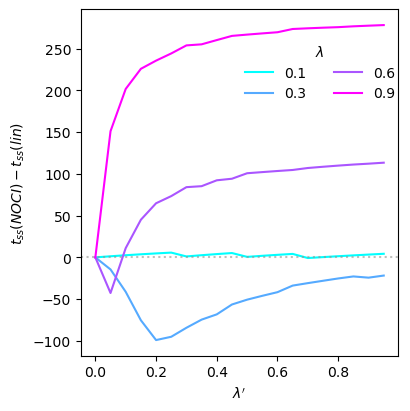

In [127]:
fig, ax = plt.subplots(1,1, figsize=(4,4), constrained_layout=True)
lcis = np.arange(0.0, 1.0, 0.05)
colors = plt.cm.cool(np.linspace(0.0, 1.0, len(ls_lci_evo_times.keys())))

### PLOT time(NO CI)-time(sigmoid)
ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(NO CI) - t_{ss}(lin)$')
# ax.set(xlabel="$\lambda'$", ylabel=r'$t_{ss}(NO CI) - t_{ss}(\sigma_1)$')
for (l,lci_evo),c in zip(ls_lci_evo_times.items(),colors):
    t0 = lci_evo['lin'][0]
    tdif = [t0-tlin for tlin in lci_evo['lin']]
    # tdif = [t0-tsig for tsig in lci_evo['sig1']]
    ax.plot(lcis, tdif, color=c, label=f'{l}')

ax.axhline(0.0, 0, 1, ls=':', color='xkcd:gray', alpha=0.6)
ax.legend(title='$\lambda$', frameon=False, loc=(0.5,0.72), ncol=2)

fig.savefig('x_lambdaci_y_tssDifNoCIlin_num_int.png')
# fig.savefig('x_lambdaci_y_tssDifNoCIsig1_num_int.png')